In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [4]:
def plot_rashomon_results(results_df, thresholds=[0.01], save_plots=True):
    """
    Create comprehensive plots for Rashomon simulation results.
    
    Parameters:
    -----------
    results_df : pandas.DataFrame
        Results from run_rashomon_simulation()
    thresholds : list
        List of thresholds used in simulation
    save_plots : bool
        Whether to save plots to files
    """
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    n_thresholds = len(thresholds)
    fig = plt.figure(figsize=(16, 12))
    
    # Plot 1: Rashomon Set Size vs Sample Size
    plt.subplot(2, 3, 1)
    for threshold in thresholds:
        col_name = f'count_{int(threshold*100)}pct'
        
        # Calculate mean and std for each sample size
        summary_stats = results_df.groupby('sample_size')[col_name].agg(['mean', 'std']).reset_index()
        
        plt.errorbar(summary_stats['sample_size'], 
                    summary_stats['mean'],
                    yerr=summary_stats['std'],
                    marker='o', 
                    label=f'{threshold*100:.1f}% threshold',
                    capsize=5)
    
    plt.xlabel('Sample Size')
    plt.ylabel('Average Rashomon Set Size')
    plt.title('Rashomon Set Size vs Sample Size')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    
    # Plot 2: True DGP Recovery Rate vs Sample Size
    plt.subplot(2, 3, 2)
    dgp_recovery_stats = results_df.groupby('sample_size')['best_is_true_dgp'].agg(['mean', 'std']).reset_index()
    
    plt.errorbar(dgp_recovery_stats['sample_size'],
                dgp_recovery_stats['mean'],
                yerr=dgp_recovery_stats['std'],
                marker='s',
                color='red',
                capsize=5,
                linewidth=2)
    
    plt.xlabel('Sample Size')
    plt.ylabel('Probability Best Model = True DGP')
    plt.title('True Model Recovery Rate')
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.ylim(0, 1)
    
    # Plot 3: DGP in Rashomon Set vs Sample Size
    plt.subplot(2, 3, 3)
    for threshold in thresholds:
        dgp_col = f'dgp_in_rashomon_{int(threshold*100)}pct'
        
        dgp_rashomon_stats = results_df.groupby('sample_size')[dgp_col].agg(['mean', 'std']).reset_index()
        
        plt.errorbar(dgp_rashomon_stats['sample_size'],
                    dgp_rashomon_stats['mean'],
                    yerr=dgp_rashomon_stats['std'],
                    marker='d',
                    label=f'{threshold*100:.1f}% threshold',
                    capsize=5)
    
    plt.xlabel('Sample Size')
    plt.ylabel('Probability DGP in Rashomon Set')
    plt.title('True Model in Rashomon Set')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.ylim(0, 1)
    
    # Plot 4: Distribution of Rashomon Set Sizes (for largest sample size)
    plt.subplot(2, 3, 4)
    largest_sample = results_df['sample_size'].max()
    largest_sample_data = results_df[results_df['sample_size'] == largest_sample]
    
    for i, threshold in enumerate(thresholds):
        col_name = f'count_{int(threshold*100)}pct'
        plt.hist(largest_sample_data[col_name], 
                alpha=0.7, 
                bins=20, 
                label=f'{threshold*100:.1f}% threshold',
                density=True)
    
    plt.xlabel('Rashomon Set Size')
    plt.ylabel('Density')
    plt.title(f'Distribution of Rashomon Sizes\n(Sample Size = {largest_sample})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Recovery rates by sample size (bar plot)
    plt.subplot(2, 3, 5)
    sample_sizes = sorted(results_df['sample_size'].unique())
    recovery_rates = [results_df[results_df['sample_size'] == ss]['best_is_true_dgp'].mean() 
                     for ss in sample_sizes]
    
    bars = plt.bar(range(len(sample_sizes)), recovery_rates, 
                   color='lightcoral', alpha=0.7, edgecolor='black')
    plt.xlabel('Sample Size')
    plt.ylabel('True Model Recovery Rate')
    plt.title('Recovery Rate by Sample Size')
    plt.xticks(range(len(sample_sizes)), [f'{ss}' for ss in sample_sizes], rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, rate in zip(bars, recovery_rates):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{rate:.2f}', ha='center', va='bottom')
    
    # Plot 6: Correlation plot (Recovery vs Rashomon size)
    plt.subplot(2, 3, 6)
    for threshold in thresholds:
        count_col = f'count_{int(threshold*100)}pct'
        dgp_col = f'dgp_in_rashomon_{int(threshold*100)}pct'
        
        # Calculate correlation by sample size
        corr_by_sample = []
        sample_sizes_for_corr = []
        
        for ss in sorted(results_df['sample_size'].unique()):
            subset = results_df[results_df['sample_size'] == ss]
            if len(subset) > 1:  # Need at least 2 points for correlation
                corr = subset['best_is_true_dgp'].corr(subset[dgp_col])
                if not np.isnan(corr):
                    corr_by_sample.append(corr)
                    sample_sizes_for_corr.append(ss)
        
        if corr_by_sample:
            plt.plot(sample_sizes_for_corr, corr_by_sample, 
                    marker='o', label=f'{threshold*100:.1f}% threshold')
    
    plt.xlabel('Sample Size')
    plt.ylabel('Correlation: Recovery vs DGP in Rashomon')
    plt.title('Recovery-Rashomon Correlation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('rashomon_simulation_plots.png', dpi=300, bbox_inches='tight')
        print("Plots saved to rashomon_simulation_plots.png")
    
    plt.show()

def plot_detailed_analysis(results_df, thresholds=[0.01]):
    """
    Create additional detailed analysis plots.
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Heatmap of recovery rates
    pivot_data = results_df.groupby(['sample_size'])['best_is_true_dgp'].mean().reset_index()
    
    # Create a pivot table for heatmap (if you have multiple thresholds)
    if len(thresholds) > 1:
        heatmap_data = []
        for threshold in thresholds:
            dgp_col = f'dgp_in_rashomon_{int(threshold*100)}pct'
            threshold_data = results_df.groupby('sample_size')[dgp_col].mean()
            heatmap_data.append(threshold_data.values)
        
        heatmap_df = pd.DataFrame(heatmap_data, 
                                 index=[f'{t*100:.1f}%' for t in thresholds],
                                 columns=[f'{ss}' for ss in sorted(results_df['sample_size'].unique())])
        
        sns.heatmap(heatmap_df, annot=True, fmt='.3f', ax=axes[0,0], cmap='YlOrRd')
        axes[0,0].set_title('DGP in Rashomon Set Rate')
        axes[0,0].set_xlabel('Sample Size')
        axes[0,0].set_ylabel('Threshold')
    else:
        # Single threshold - show recovery rate by sample size
        sample_sizes = sorted(results_df['sample_size'].unique())
        recovery_by_size = [results_df[results_df['sample_size'] == ss]['best_is_true_dgp'].mean() 
                           for ss in sample_sizes]
        
        axes[0,0].bar(range(len(sample_sizes)), recovery_by_size, color='skyblue', alpha=0.7)
        axes[0,0].set_xticks(range(len(sample_sizes)))
        axes[0,0].set_xticklabels([str(ss) for ss in sample_sizes])
        axes[0,0].set_title('True Model Recovery Rate by Sample Size')
        axes[0,0].set_xlabel('Sample Size')
        axes[0,0].set_ylabel('Recovery Rate')
    
    # Plot 2: Box plot of Rashomon sizes by sample size
    threshold = thresholds[0]  # Use first threshold
    col_name = f'count_{int(threshold*100)}pct'
    
    sample_size_data = []
    sample_size_labels = []
    for ss in sorted(results_df['sample_size'].unique()):
        subset = results_df[results_df['sample_size'] == ss]
        sample_size_data.append(subset[col_name].values)
        sample_size_labels.append(str(ss))
    
    axes[0,1].boxplot(sample_size_data, labels=sample_size_labels)
    axes[0,1].set_title(f'Rashomon Set Size Distribution\n({threshold*100:.1f}% threshold)')
    axes[0,1].set_xlabel('Sample Size')
    axes[0,1].set_ylabel('Rashomon Set Size')
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Scatter plot - sample size vs metrics
    axes[1,0].scatter(results_df['sample_size'], results_df['best_is_true_dgp'], 
                     alpha=0.6, s=20, color='red', label='Best = DGP')
    
    dgp_col = f'dgp_in_rashomon_{int(threshold*100)}pct'
    axes[1,0].scatter(results_df['sample_size'], results_df[dgp_col], 
                     alpha=0.6, s=20, color='blue', label='DGP in Rashomon')
    
    axes[1,0].set_xlabel('Sample Size')
    axes[1,0].set_ylabel('Binary Outcome')
    axes[1,0].set_title('Individual Simulation Results')
    axes[1,0].legend()
    axes[1,0].set_xscale('log')
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Summary table as text
    axes[1,1].axis('off')
    
    # Create summary statistics
    summary_text = "SIMULATION SUMMARY\n" + "="*30 + "\n\n"
    
    for ss in sorted(results_df['sample_size'].unique()):
        subset = results_df[results_df['sample_size'] == ss]
        recovery_rate = subset['best_is_true_dgp'].mean()
        dgp_in_rashomon_rate = subset[dgp_col].mean()
        avg_rashomon_size = subset[col_name].mean()
        
        summary_text += f"Sample Size {ss}:\n"
        summary_text += f"  Recovery Rate: {recovery_rate:.3f}\n"
        summary_text += f"  DGP in Rashomon: {dgp_in_rashomon_rate:.3f}\n"
        summary_text += f"  Avg Rashomon Size: {avg_rashomon_size:.1f}\n\n"
    
    axes[1,1].text(0.05, 0.95, summary_text, transform=axes[1,1].transAxes,
                   fontsize=10, verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()

# Example usage function
def create_all_plots(results_df, thresholds=[0.01]):
    """
    Create all plots for the Rashomon simulation results.
    """
    print("Creating main plots...")
    plot_rashomon_results(results_df, thresholds)
    
    print("Creating detailed analysis plots...")
    plot_detailed_analysis(results_df, thresholds)
    
    print("All plots created!")

# Quick plotting function for testing
def quick_plot_test():
    """
    Test the plotting functions with sample data.
    """
    # Create some sample data for testing
    np.random.seed(42)
    n_samples = 400
    sample_sizes = [50, 1000, 5000, 10000]
    
    test_data = {
        'sample_size': np.repeat(sample_sizes, n_samples // len(sample_sizes)),
        'iteration': np.tile(range(n_samples // len(sample_sizes)), len(sample_sizes)),
        'best_is_true_dgp': np.random.binomial(1, 0.3, n_samples),
        'count_1pct': np.random.poisson(5, n_samples),
        'dgp_in_rashomon_1pct': np.random.binomial(1, 0.8, n_samples)
    }
    
    test_df = pd.DataFrame(test_data)
    
    print("Running plotting test with sample data...")
    plot_rashomon_results(test_df, thresholds=[0.01], save_plots=False)
    
    return test_df

Loading simulation results...
Found results for thresholds: ['1%', '5%']
Sample sizes: [500, 1000]
Number of iterations: 100

Creating plots and saving to ../plots/...


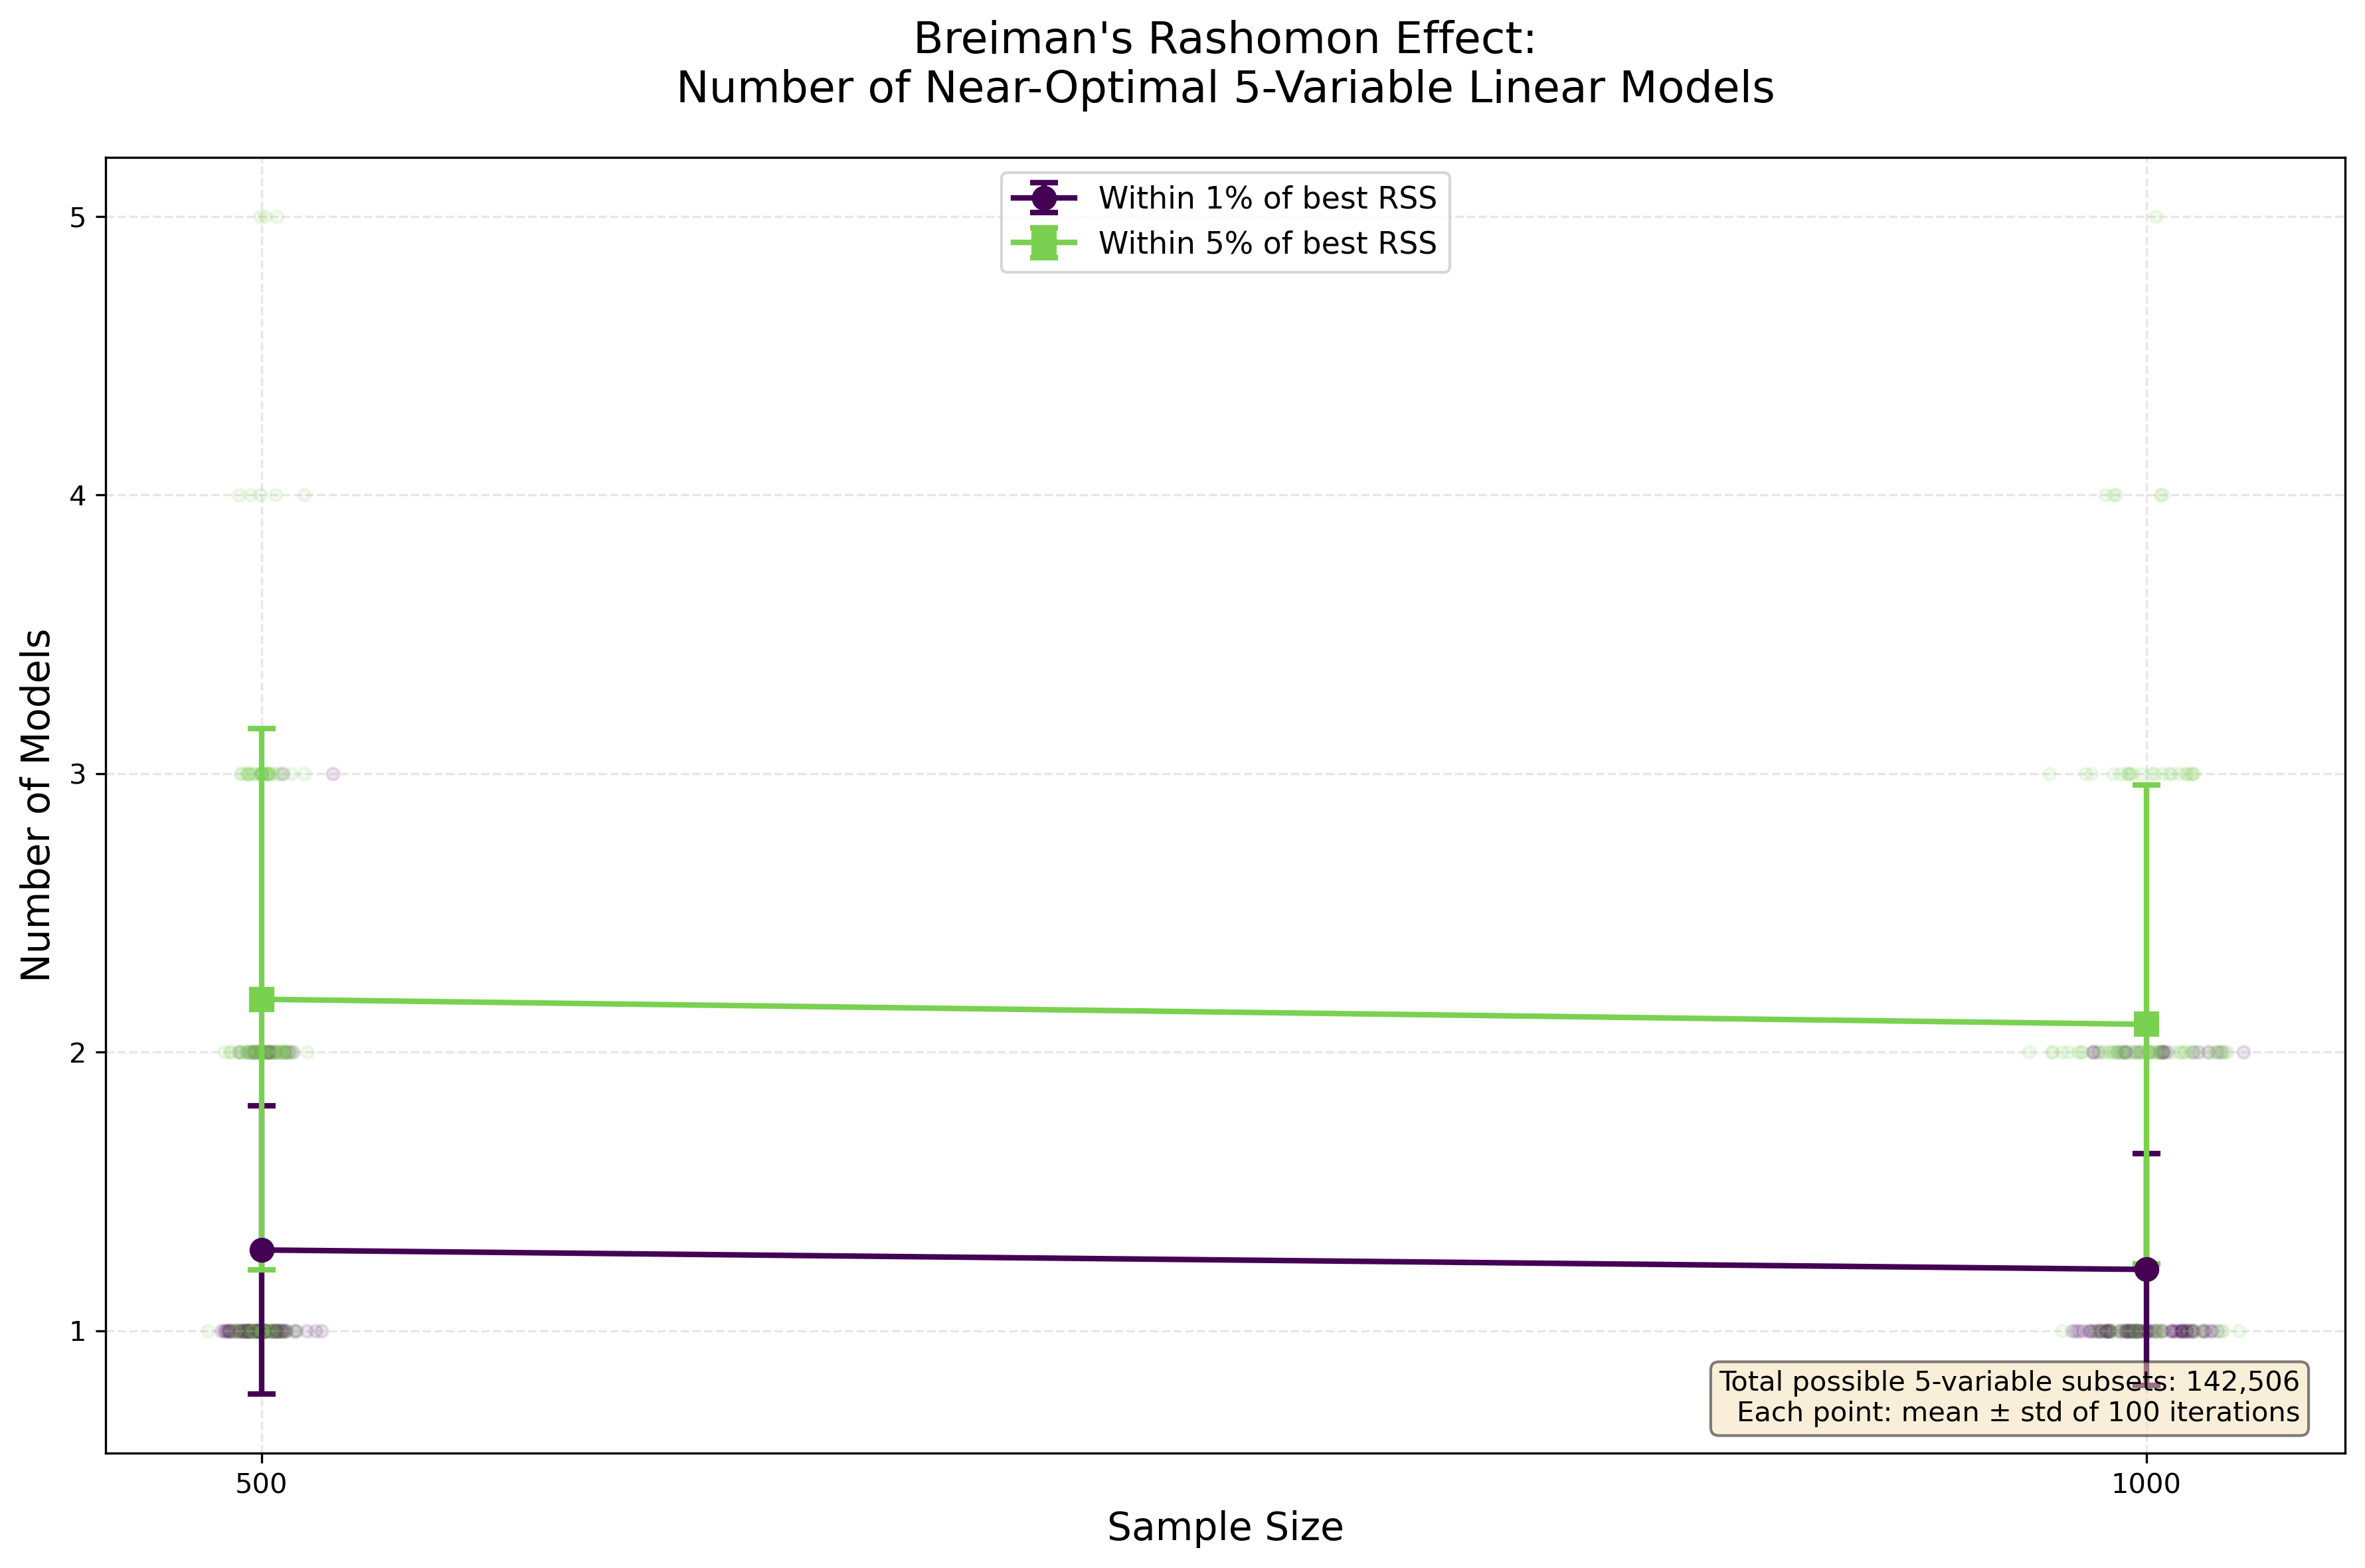

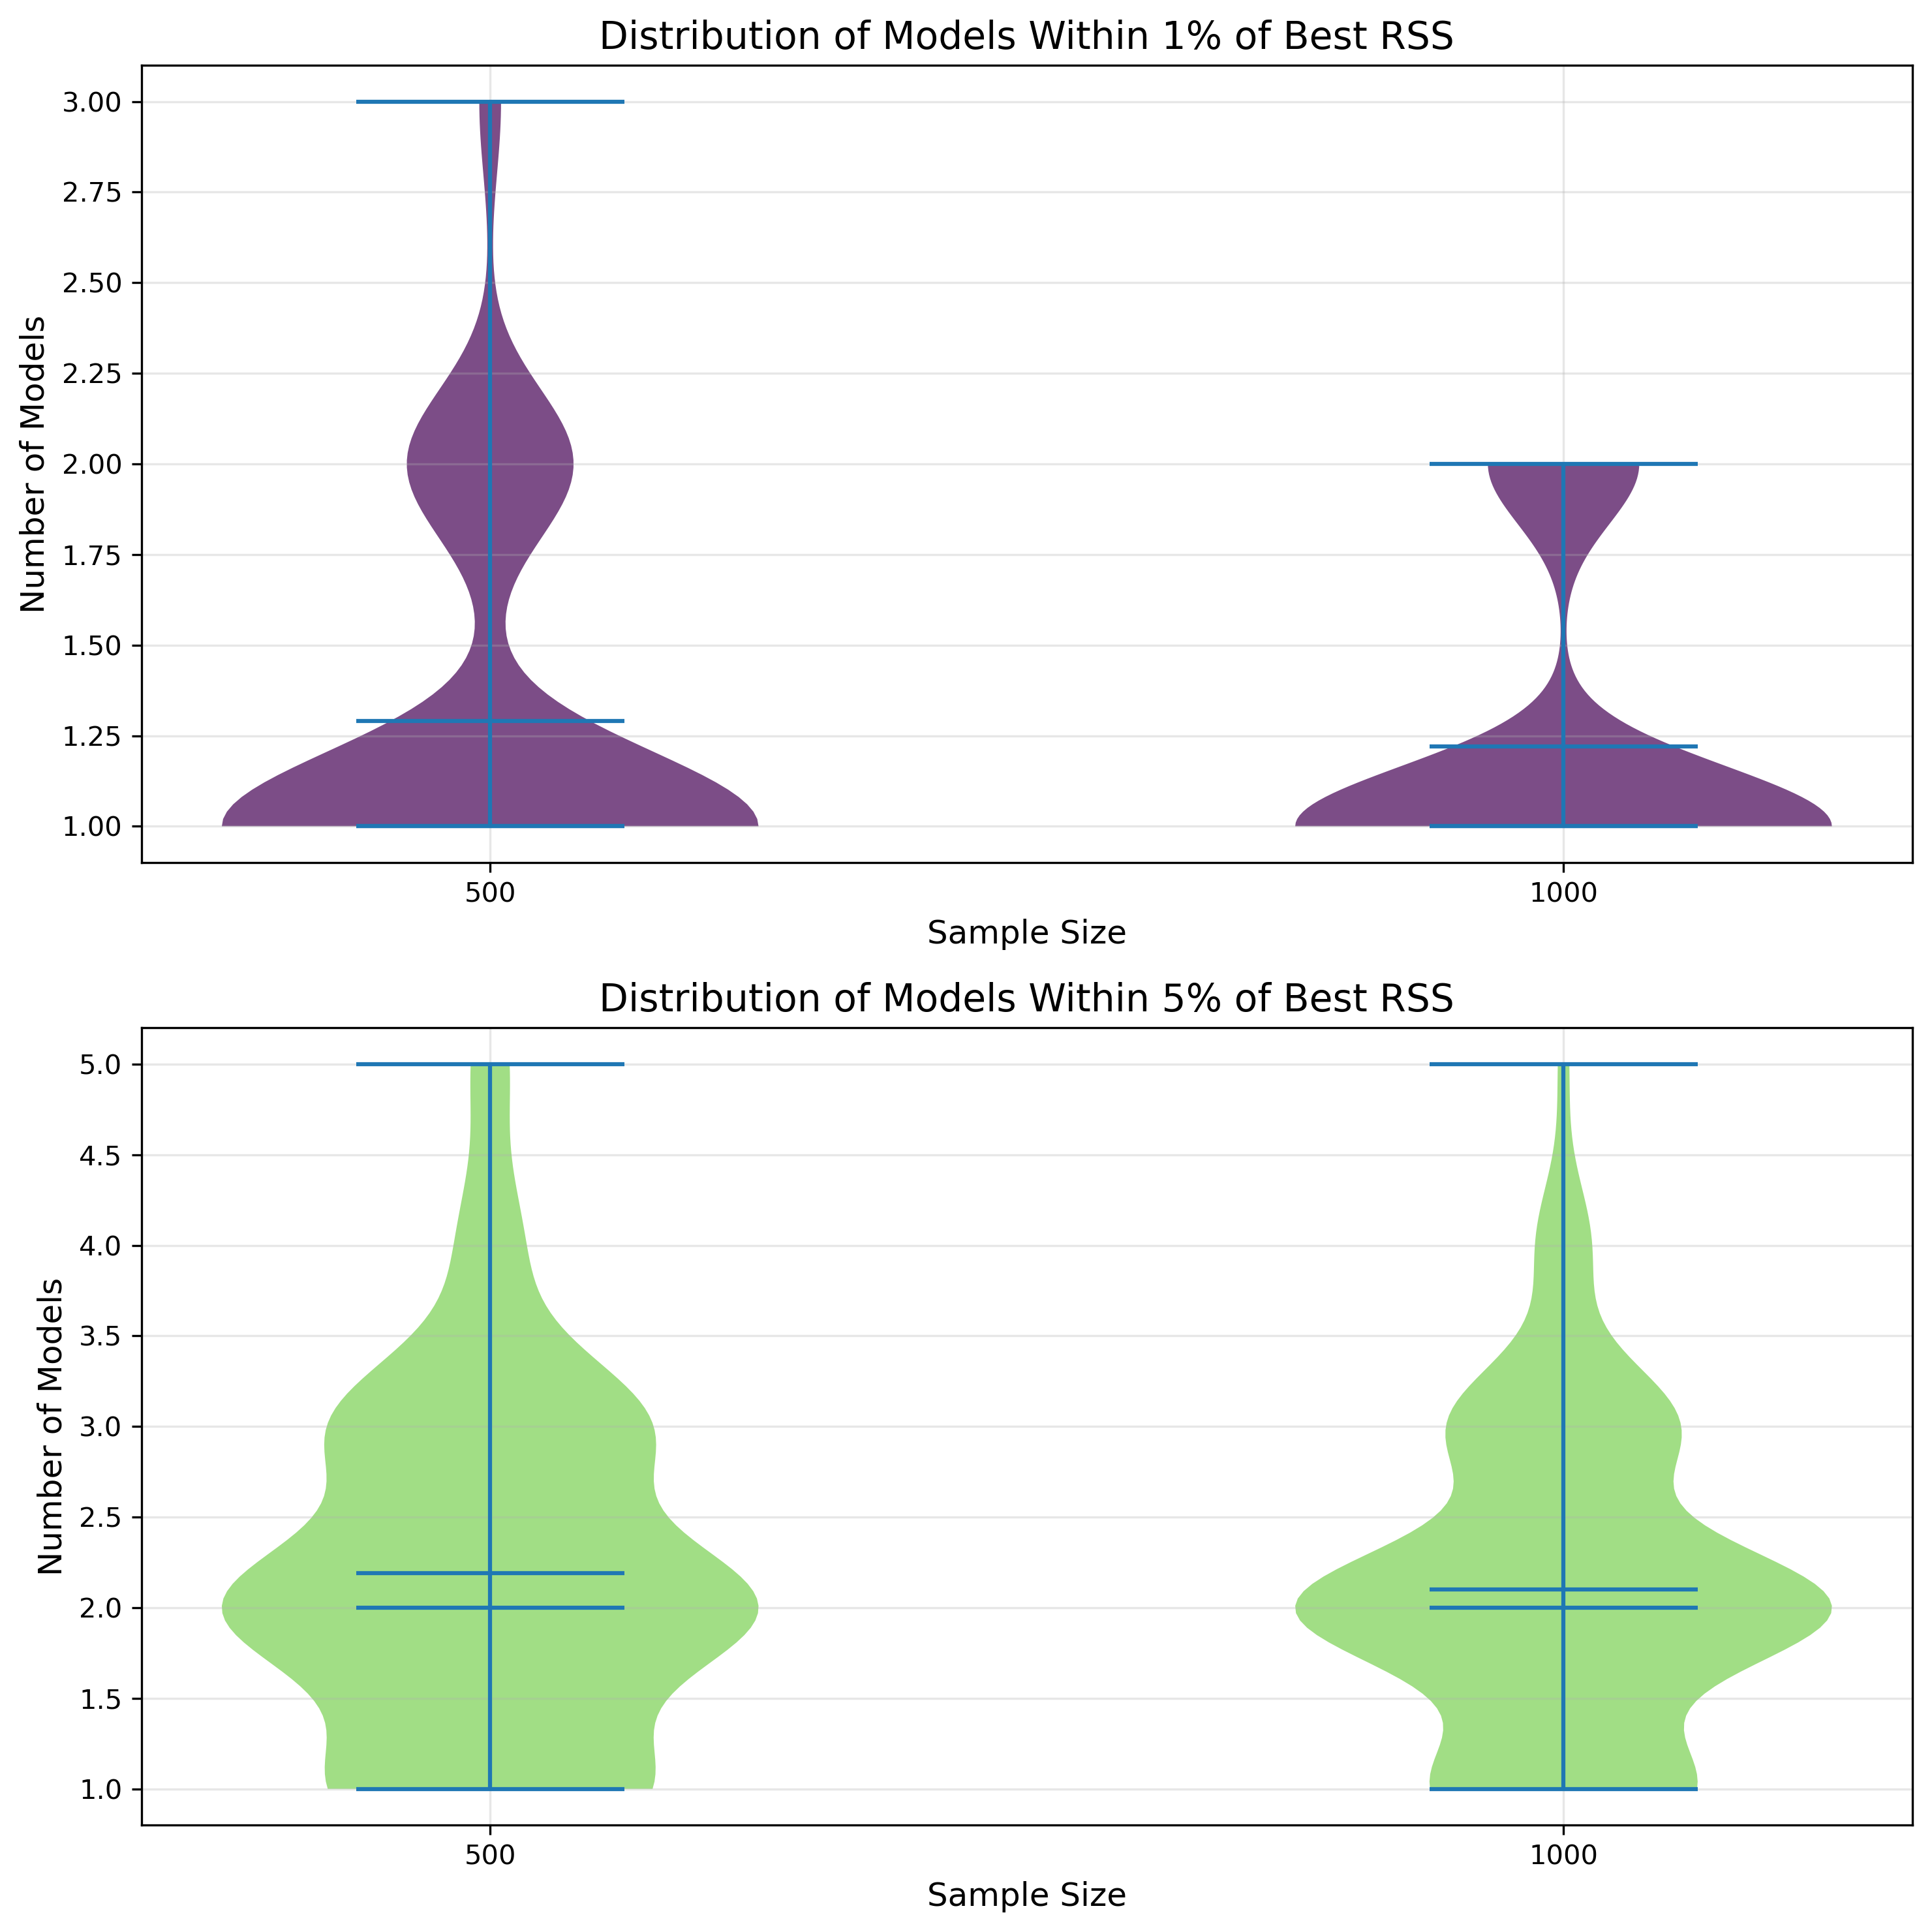


Detailed Statistics for Breiman's Rashomon Effect

Sample Size: 500
----------------------------------------

Models within 1% of best RSS:
  Mean:     1.3
  Std Dev:  0.5
  Median:   1
  Min:      1
  Max:      3
  25th %:   1
  75th %:   2

Models within 5% of best RSS:
  Mean:     2.2
  Std Dev:  1.0
  Median:   2
  Min:      1
  Max:      5
  25th %:   2
  75th %:   3

Sample Size: 1000
----------------------------------------

Models within 1% of best RSS:
  Mean:     1.2
  Std Dev:  0.4
  Median:   1
  Min:      1
  Max:      2
  25th %:   1
  75th %:   1

Models within 5% of best RSS:
  Mean:     2.1
  Std Dev:  0.9
  Median:   2
  Min:      1
  Max:      5
  25th %:   2
  75th %:   3

Total number of possible 5-variable subsets: 142,506
Number of iterations per sample size: 100

High-quality plots saved to ../plots/:
  - rashomon_effect_plot.png/pdf/svg (DPI: 300)
  - rashomon_effect_distributions.png/pdf (DPI: 300)
  - rashomon_effect_comparison.png/pdf (DPI: 300)


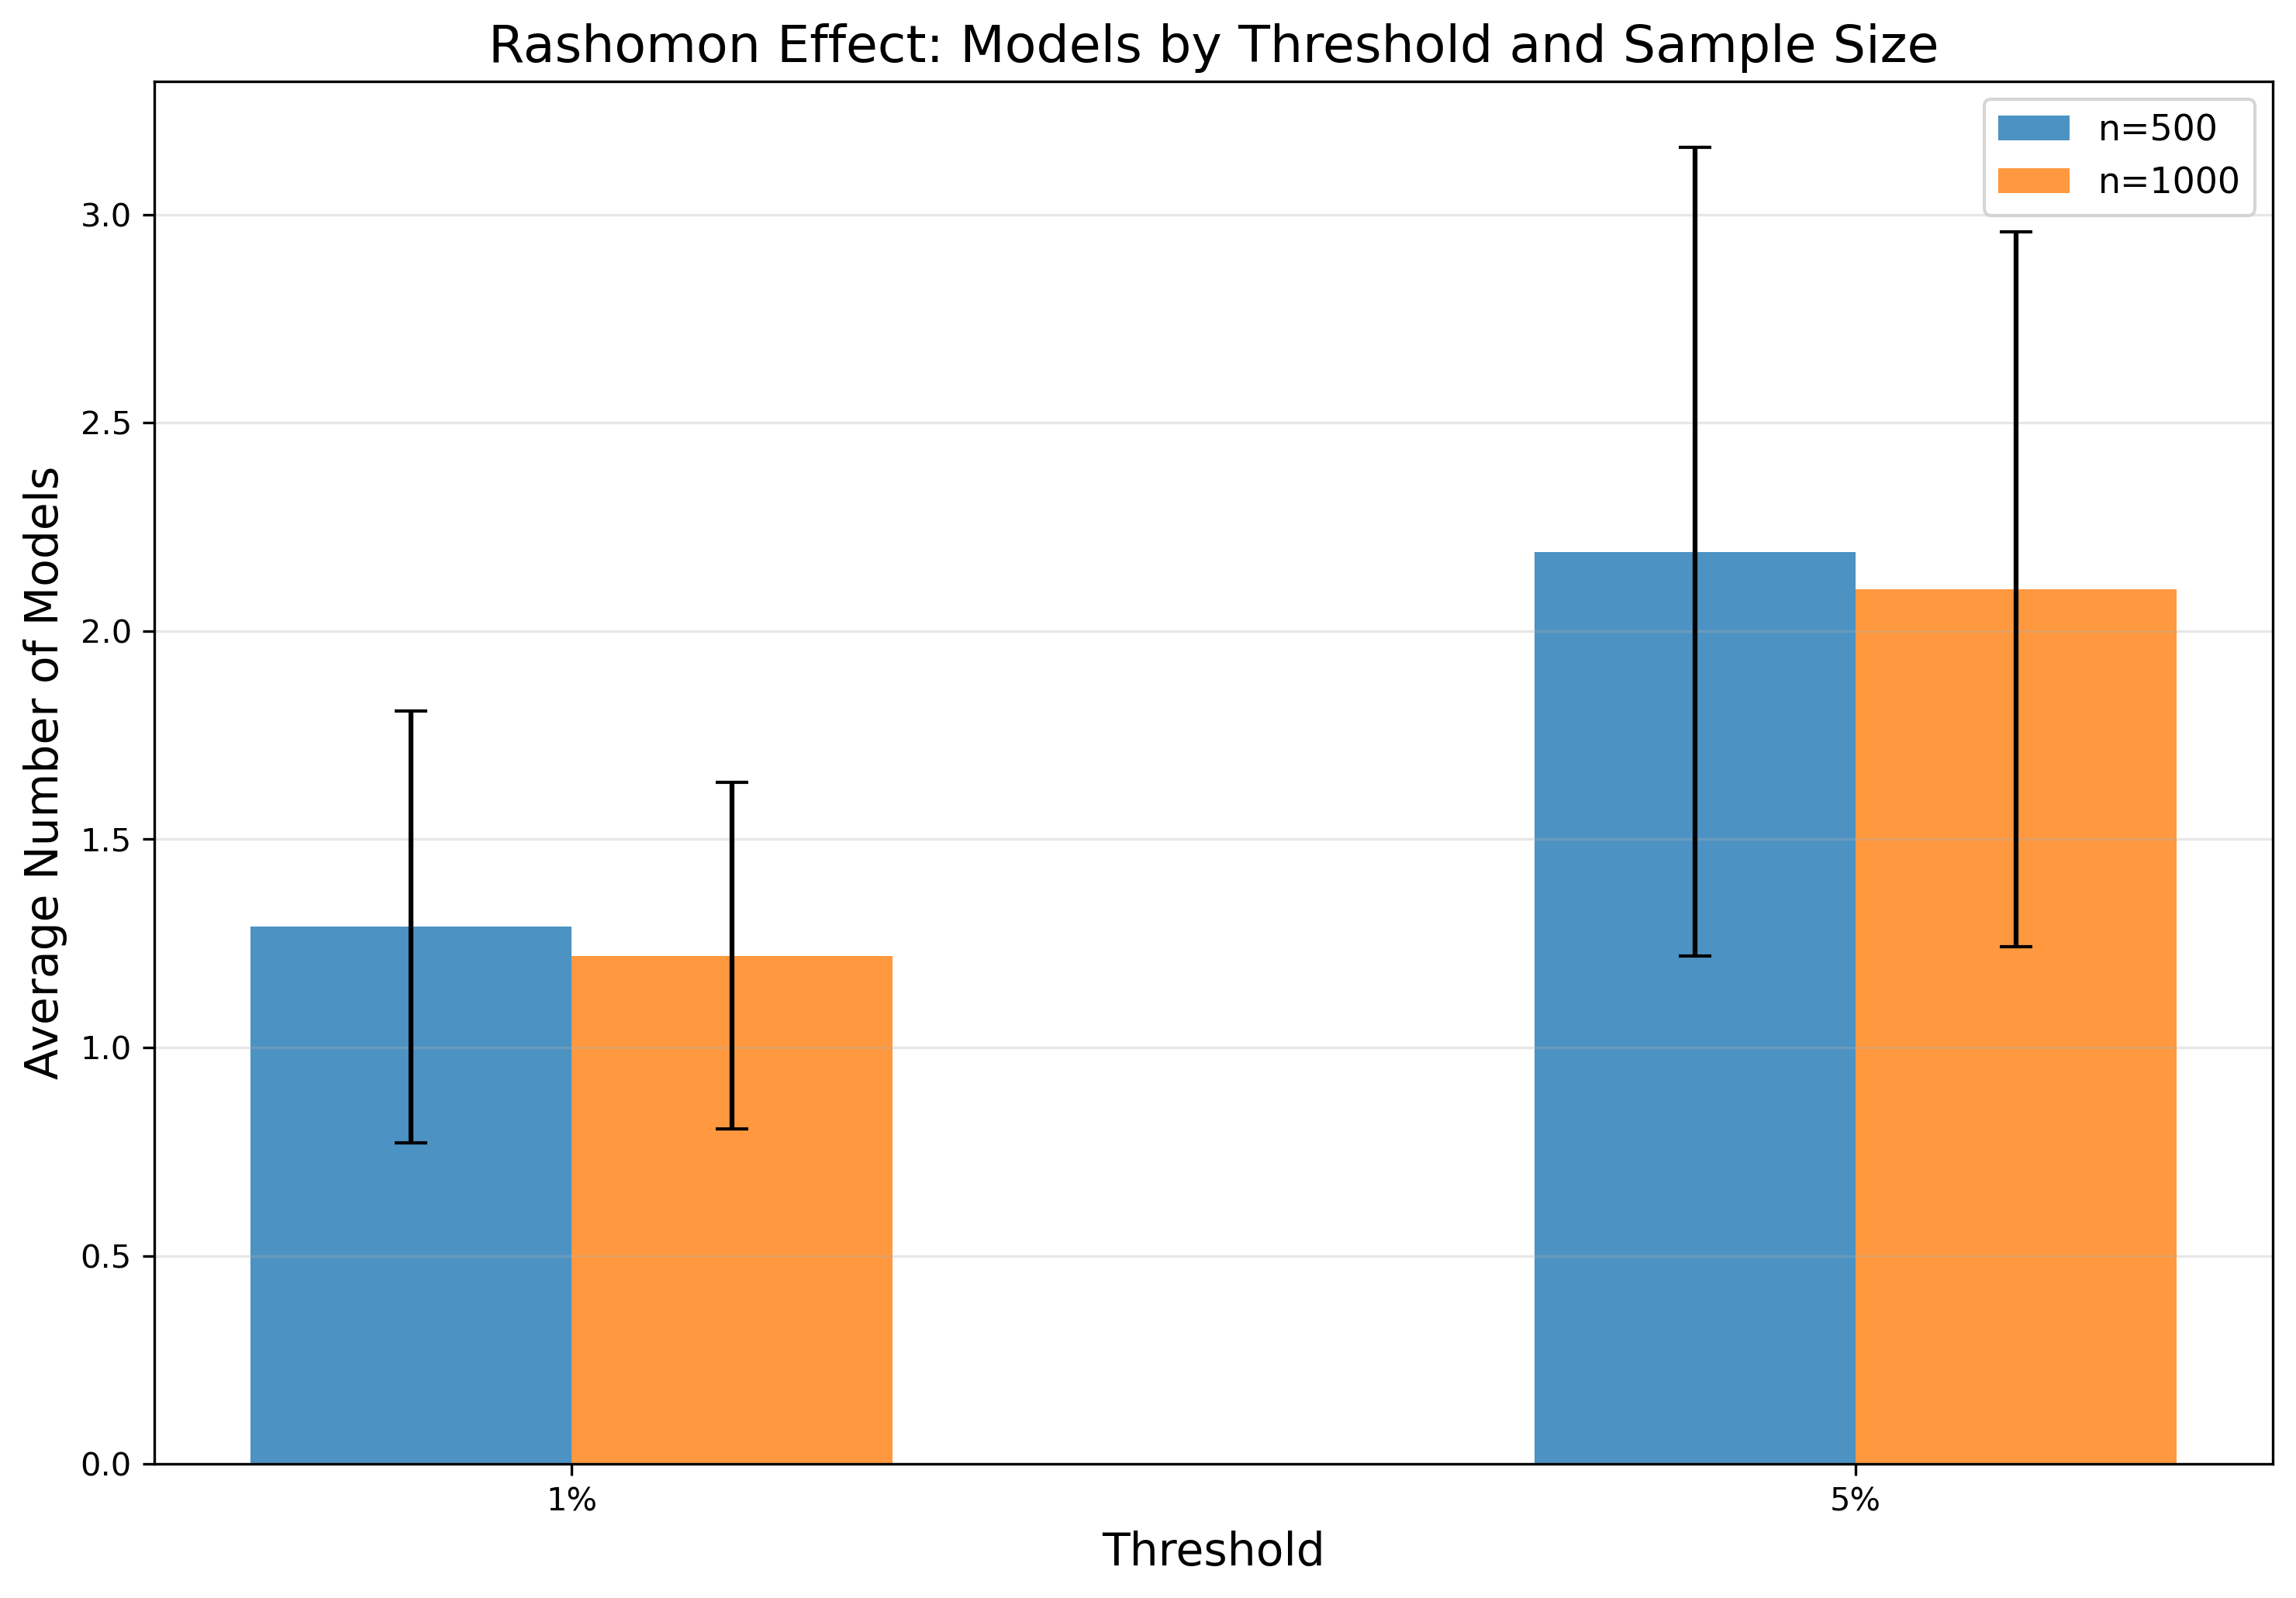

In [5]:
if __name__ == "__main__":
    main(
        csv_filepath='../results/bootstrap_sim.csv',
        output_dir='../plots/',
        dpi=300 
    )